# Characteristic-based Clustering For Bicycle Ride Trajectories

In this notebook, we will cluster a dataset of smart bicycle ride characteristics extracted from a directory of GPX routes using unsupervised learning techniques in the form of a Gaussian Mixture Model.  The goal is to uncover ex ante patterns in physical dimensions of the routes in a manner that is time, location, and rider-invariant.  The resulting segmentation of the routes can then be mapped ex post in a spatial/temporal manner for analytical purposes.

This notebook will proceed as follows:

- Approach
- About The Data
- Feature Engineering from GPX files
    - Data Summary
    - Visualizing Distribution Of Data
    - Correlation/Covariance Analysis
    - Principal Components Analysis
- Clustering with Gaussian Mixture Models
- Prototypes and Outlier Analysis

## Approach

A traditional longitudinal clustering procedure is codified into four components in S. Arghaborzorgi et al. that we borrow for our approach here.  There are:

1. Time-series Representation
2. Similarity or Distance Measures
3. Clustering Procedure
4. Clustering Prototypes

The approach itself is a generalization of a "Characteristic-Based Clustering for Time Series Data" ([1](https://www.researchgate.net/publication/220451959_Characteristic-Based_Clustering_for_Time_Series_Data)) to bicycle ride trajectories.  Our method does not cluster point values using a distance measure, but it clusters global features extracted from each time series.

## About The Data

The GPX routes were generated from embedded bicycles in the JUMP Bicycles pilot bike share program and collected over a period of three months during the summer of 2013 from Hoboken, New Jersey.  A GPX "track" consists of a sequence of "trackpoints" generated at a fixed time interval and each track contains a lattitue and longitude value.  The metadata of the GPX files contain information about the starting time of the routes in UTC which are not used as input to the segmentation routine.  GPX is a standarized format of XML and thus is easily traversed using the principals of the "Document Object Model" (DOM).

Let's read the data in from its serialized format.  Subset the data with our features of interest.  Note that we are clustering on "location-agnostic" features, as we are solely concerned with the nature of the ride vectors themselves.

In [50]:
# Import libraries: NumPy, pandas, matplotlib, metrics
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sn


# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_distances

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Change working directory.
os.chdir(os.getcwd())

## Smartbike Trajectory Representation / Feature Engineering

We are pursuing what is known as a "feature-based" time-series clustering approach ([1](https://www.sciencedirect.com/science/article/pii/S0031320305001305?via%3Dihub)).
  The goal is to extract features into lower dimensional, equal-length vectors for clustering ([2](https://umexpert.um.edu.my/file/publication/00005678_120457.pdf)).  Dimensionality reduction will greatly speed up the clustering routine as the similarity calculation scales exponentially with the number of features, and will reduce noise in the dataset (from both riders and sensor errors) to near-negligible levels.  The form of extraction is classified as "non-data adaptive" as opposed to "data adaptive" as there are no parameters in the extraction.

The chosen features we extract are:

- dwell_ratio: percentage of total ride time with an estimate velocity under 3mph
- todest_ratio: percentage of total ride time in which distance from ride origin was increasing
- inride_mph: average speed in mph of a rider for segments exceeding 3mph
- turns/500m: average number of changes of headings in excess of 45 degrees made per 500 meters

In [51]:
# Read dataset.
data = pd.read_pickle("data/data.pkl")

# Subset select metrics.
select_metrics = ['dwell_ratio', 'todest_ratio', 'inride_mph', 'turns/500m']

# Describe data.
print(data[select_metrics].describe())

       dwell_ratio  todest_ratio   inride_mph   turns/500m
count  1028.000000   1028.000000  1028.000000  1028.000000
mean      0.170437      0.883507    16.992453     1.648439
std       0.157820      0.166307     3.822535     0.933851
min       0.000000      0.333333     6.662694     0.245216
25%       0.066667      0.846154    14.300982     1.001893
50%       0.133333      0.953463    16.818530     1.503005
75%       0.230769      1.000000    19.470314     2.105131
max       0.875940      1.000000    28.277262     7.457226


#### Feature Exploration

Let's explore the nature of our characteristics by plotting their histograms and quantile-quantile (QQ) plots.  We choose to evaluate our features with respect to normally-distributed data, so our QQ-plots plot quantiles against z-scores from a normal distribution.

We see that inride_mph appears to be normally distributed, and that log of turns/500m with a non-zero adjustment is nearly normal.  dwell_ratio and todest_ratio are heavily skewed, and the multi-modality and peakedness of the endpoint values suggest latent features make these features highly non-normal.  Interpretation of these measures is left as a further research, but we might expect that these features could be normal after controlling for type from the clustering routine.

((array([-3.20554261, -2.94093949, -2.79331915, ...,  2.79331915,
          2.94093949,  3.20554261]),
  array([0.21930862, 0.22146264, 0.22581839, ..., 1.98832797, 1.99900976,
         2.13502124])),
 (0.3214844736804363, 0.9199835412573402, 0.9949143411766833))

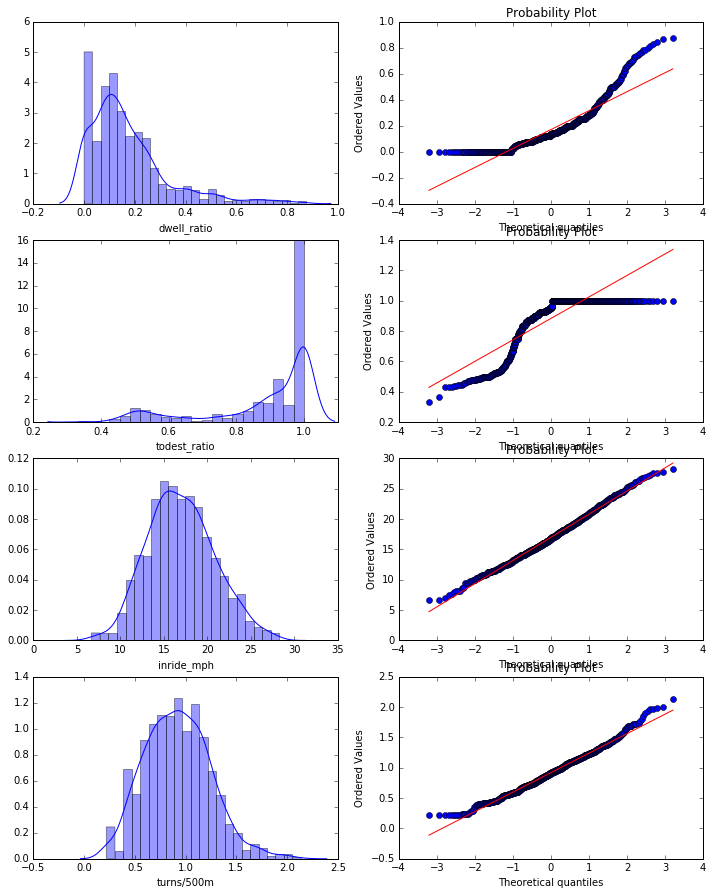

In [89]:
# Set up plotting canvas and subplots.
fig,axes = plt.subplots(ncols=2,nrows=4)
fig.set_size_inches(12, 15)

# For each feature, plot binned-histogram on left and QQ-plot on right.
sn.distplot((data['dwell_ratio']),ax=axes[0][0])
stats.probplot(data['dwell_ratio'], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(data['todest_ratio'],ax=axes[1][0])
stats.probplot(data['todest_ratio'], dist='norm', fit=True, plot=axes[1][1])
sn.distplot(data['inride_mph'],ax=axes[2][0])
stats.probplot(data['inride_mph'], dist='norm', fit=True, plot=axes[2][1])
sn.distplot(np.log1p(data['turns/500m']),ax=axes[3][0])
stats.probplot(np.log1p(data['turns/500m']), dist='norm', fit=True, plot=axes[3][1])

#### Correlation Analysis

We are now turn our attention to the covariance of our features.  Independence assumptions are not a requirement for partitioning clustering methods and in practice highly correlated features do not greatly affect cluster outputs.  However, redundancy does have effects on routine performance so we would be concerned with correlation coefficients in excess of about 0.8.

Through the correlation matrix below, we see that that the negative cross-correlation between inride_mph and turns/500m is the only interaction of great concern.  We might expect then that its omission from clustering would not greatly affect our results if we were to cluster on these feature.  If we were more concerned about program performance we would drop this feature altogether but for purposes of generality to bicycle trajectories in other regions, we choose to include it and carry it forward to the principle components analysis.

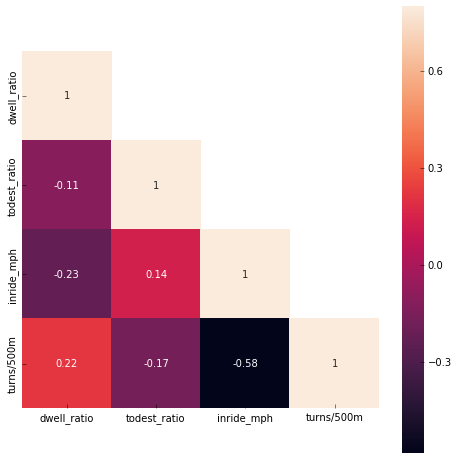

In [91]:
# Plot a correlation matrix with a heat map.
corrMatt = data[select_metrics].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(8,8)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

#### Principal Components Analysis

We pursue the following PCA decomposition routine for two purposes: 1. to explore interactions between features, and 2. for dimensionality reduction.  We know that the basis vectors of PCA will form an orthonormal and independent set and therefore that the composition of these basis vectors in terms of the original features will provide multi-dimensional information relevant to a clustering routine.  We normalize our features to be constrianed to the [0,1] space so as not to privilege any one feature in the analysis.

Specifically, the PCA decomposition of our dataset shows that the top 3 eigenvectors "explain" about 93% of the total variance in our data.  The first eigenvector has an eigenvalue of about 0.42 corresponding to 42% explained variance, and its composition in terms of the features is positively significant from dwell_ratio, positively moderate from turns/500m, and moderately negative from 'todest_ratio' and 'inride_mph'.  Intuitively we might surmise that an indiviual bicycle trajectory with strong response to this first PCA is generated from a slow, round-about rider.  Conversely, a bicycle trajectory with a strong negative response to this eigenvector might have been generated from a fast, direct rider.  The second and third eigenvectors just about share the remainder of the 93% explained variance figure and seem to decouple quick, round-about trajectories from slow, round-about trajectories.

Finnaly, using a rule-of-thumb heuristic in the concavity of the ranked eigenvectors vs. explained variance chart, we choose to project our dataset onto these three vectors for the clustering routine.

Original features are:
['dwell_ratio', 'todest_ratio', 'inride_mph', 'turns/500m']

PCA components are:
[[ 0.72681856 -0.40482435 -0.41086569  0.37288257]
 [-0.53470254 -0.84028239 -0.05142935  0.07330567]
 [ 0.43106443 -0.35950999  0.63408715 -0.53185478]
 [-0.00337954  0.02820147  0.65305275  0.7567796 ]]

Ranked explained variance of PCA components:
[0.42480993 0.27680578 0.223386   0.0749983 ]

Total explained variance of PCA components:
1.0


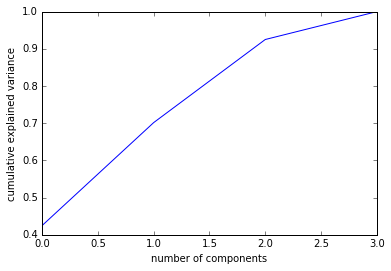

In [93]:
# Init PCA object.
pca_components = 4
pca = PCA(n_components=pca_components)

# Normalize attributes.
standardized_data = (data[select_metrics])/(data[select_metrics].max())

# Fit it to the data.
pca.fit(standardized_data)
    
# Project into PCA coordinates.
fit_data = pd.DataFrame(pca.transform(standardized_data))
fit_data = fit_data.rename(index=str, columns={0: "PCA_1", 1: "PCA_2", 2: "PCA_3"})

# Print the components and the amount of variance in the data contained in each dimension
print "Original features are:\n", ['dwell_ratio', 'todest_ratio', 'inride_mph', 'turns/500m']

print "\nPCA components are:\n", pca.components_
print "\nRanked explained variance of PCA components:\n", pca.explained_variance_ratio_
print "\nTotal explained variance of PCA components:\n", sum(pca.explained_variance_ratio_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Similarity

How to measure similarity of rides?

Euclidean distance in a PCA subspace.


Similarity in time? No.  Do not care about time.
Similarity in shape? Yes.  More apropriate for short time series
Similarity in structure??  Possibly.

Which similarity measure to use?  Euclidean.  It is appropriate for shape, widely used, interpretable, and competitive with other measures.


## Cluster

Clustering is GMM with partitioning (as opposed to hierarchical).  We prefer probabilistic interpretation as a ride type can certainly change mid-route, or even be a combination of two types.

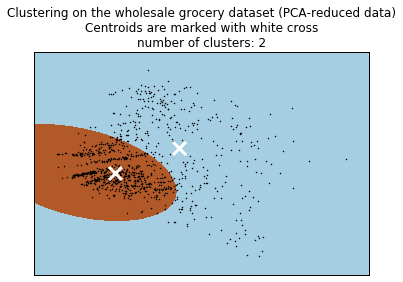

Clustering has a Silhouette Score of 0.442935783002


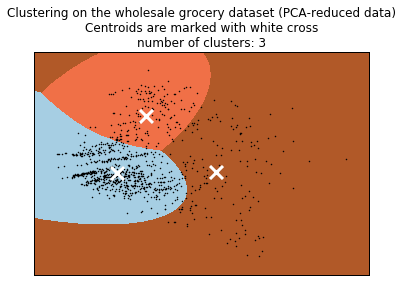

Clustering has a Silhouette Score of 0.457803368959


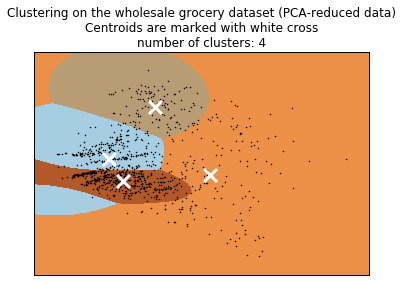

Clustering has a Silhouette Score of 0.296332378288


In [66]:
# Project to two dimension for visualization.
viz_components = 2
pca2 = PCA(n_components=viz_components)

# Fit it to the data.
pca2.fit(standardized_data)
    
# Project into PCA coordinates.
reduced_data = pca2.transform(standardized_data)


# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min()- .1, reduced_data[:, 0].max() + .1
y_min, y_max = reduced_data[:, 1].min() - .1, reduced_data[:, 1].max() + .1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Range of clusters
cluster_range = [2,3,4]

# Plotting Routine
for cluster_num in cluster_range:
    GMM_clf = GaussianMixture(n_components=cluster_num,covariance_type="full").fit(reduced_data)
    GMM_pred = GMM_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    GMM_centroids = GMM_clf.means_
    reshaped_pred = GMM_pred.reshape(xx.shape)
   
    #KMeans_clf = KMeans(n_clusters=cluster_num).fit(reduced_data)
    #KMeans_pred = KMeans_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #KMeans_centroids = KMeans_clf.cluster_centers_
    #reshaped_pred = KMeans_pred.reshape(xx.shape)

    plt.figure(cluster_num)
    plt.clf()
    plt.imshow(reshaped_pred, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(GMM_centroids[:, 0], GMM_centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross\n'
              'number of clusters: {}'.format(cluster_num))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

    labels = GMM_clf.predict(reduced_data)
    ss = silhouette_score(reduced_data, labels, metric='euclidean')
    print "Clustering has a Silhouette Score of {}".format(ss)


In [85]:
cluster_num = 3
final_gmm = GaussianMixture(n_components=cluster_num,covariance_type="full").fit(fit_data)
average_customer = pca.inverse_transform(final_gmm.means_)

# COUNTS!
labels = pd.DataFrame(final_gmm.predict(fit_data))
scores = pd.DataFrame(final_gmm.predict_proba(fit_data))

## ['dwell_ratio', 'todest_ratio', 'inride_mph']
print "\nAverage ride characteristics of",cluster_num,"ride types:","\n\n", average_customer

ss = silhouette_score(fit_data, labels, metric='euclidean')
print "\nClustering has a Silhouette Score of {}".format(ss)


Average ride characteristics of 3 ride types: 

[[0.39612514 0.87516048 0.5147159  0.34025398]
 [0.13631683 0.96882703 0.62869669 0.18665701]
 [0.20205779 0.59132242 0.58767164 0.22526458]]

Clustering has a Silhouette Score of 0.34436997703


## Cluster Prorotypes

We need to find the prototype rides for each cluster, which is equivalent to finding the ride from which the total dissimilarity of all other rides in the type is minimized.  This is also called the "Steiner Sequence".  For a euclidean-based similariy, we accept the ride closest to the "centroid" of the cluster as the prototype.

## Evaluation

"In general, evaluating of extracted clusters is not easy in the absence of data labels [26] and it is still an open problem. The definition of clusters depends on the user, the domain, and it is subjective. "

We must use an "internal index" as we do not know what types of rides were being made.  "Internal Index: this index is used to measure the goodness of a clustering structure without respect to external information. In the literature, this index is known also as internal criterion, internal validation, intrinsic and unsupervised methods."



need to look at:
- sse
- intercluster distance

In [ ]:
data.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)
scores.reset_index(drop=True, inplace=True)

output = pd.concat([data.route_id, data[select_metrics], labels, scores], axis=1)
output.to_csv('cluster_final.csv')

## Discussion

TODO: try a "raw data" approach that skips the feature extration, perhaps by taking samples of the TS as fixed intervals